In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use("ggplot")
pd.set_option("display.max_columns",300)
from pandas.tools.plotting import scatter_matrix


from basis_expansions.basis_expansions import (
    Polynomial, LinearSpline, NaturalCubicSpline) 

from regression_tools.dftransformers import (
    ColumnSelector, Identity, FeatureUnion, MapFeature, Intercept)

from regression_tools.plotting_tools import (
    plot_univariate_smooth,
    bootstrap_train,
    display_coef,
    plot_bootstrap_coefs,
    plot_partial_depenence,
    plot_partial_dependences,
    predicteds_vs_actuals)


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

# Questions

1. Can I predict income inequality in a county (measured by difference between top income quintile and bottom income quintile) based on factors like:
    - Educational attainment - 
    - Proportion of population major ethnic groups - 
    - Population density - **done**
    - Birth rate - **done**
    - Unemployment rate - need to find
    - Target - diff between lowest and highest quintile **done** https://factfinder.census.gov/faces/tableservices/jsf/pages/productview.xhtml?src=bkmk
        - this will be positive, bounded by zero. 
        - likely NA's for some low-pop counties
2. Does median education rate impact income inequality?
3. Does birth rate impact income inequality?

# Goals for 3/13

1. Procure all listed datapoints not already in the data folder
2. Initial EDA to determine distribution of data and appropriate treatment
3. Figure out how to use:
    - education 
        - just median # of year at school?
        - **this option** - distribution across buckets (no high school diploma, some college, college degree, graduate degree)
    - major ethnic groups
        - **this option** - should do proportions of each race within county?
        - is there a standard measure of diversity?

In [60]:
def remove_columns(df, keyword):
    for column_name in df.columns:
        if keyword in column_name:
            df.drop(column_name, axis=1, inplace=True)
    return df

In [61]:
def update_column_names(df, phrase_to_remove, phrase_to_append=''):
    column_list = []
    for column_name in df.columns:
        if phrase_to_remove in column_name:
            column_name = column_name.replace(phrase_to_remove,'') + ' ' + phrase_to_append
        column_list.append(column_name.strip())
    df.columns = column_list
    return df

In [62]:
def add_pct_columns(df, column_names_to_pct, denom_column_name):
    for column_name in column_names_to_pct:
        df[column_name+'%'] = df[column_name]/df[denom_column_name]
    return df

In [63]:
def convert_to_pct_columns(df, column_names_to_pct, denom_column_name):
    for column_name in column_names_to_pct:
        df[column_name] = df[column_name]/df[denom_column_name]
    return df

In [64]:
''' Quintiles prep

Table is grouped by county with income means for 5 quintiles and mean for top 5%

Get data from here https://factfinder.census.gov/faces/tableservices
B19081	MEAN HOUSEHOLD INCOME OF QUINTILES
Universe: Households
Geography: All counties in US
2011-2015 American Community Survey 5-Year Estimate
'''

quintiles = pd.read_csv('data/ACS_15_5YR_B19081_with_ann.csv', header=1, encoding = "ISO-8859-1")

# drop redundant ID column
quintiles.drop('Id', axis=1, inplace=True)
# remove error columns
quintiles = remove_columns(quintiles,'Error')
# update column names to remove redundant header elements
quintiles = update_column_names(quintiles, 'Estimate; Quintile Means: - ','Mean')
# rename county columns to be consistent with other tables, rename top 5 mean to be consistent with other columns
quintiles.rename(columns={'Id2':'County_Code','Geography':'County_State','Estimate; Top 5 Percent':'Top 5% Mean' }, inplace=True)

# create income disparity column
quintiles['Diff HighestQ-LowestQ'] = quintiles['Highest Quintile Mean']\
                                    - quintiles['Lowest Quintile Mean']
quintiles['Diff Top5%-LowestQ'] = quintiles['Top 5% Mean']\
                                    - quintiles['Lowest Quintile Mean']


''' Birth Rate Prep '''

# Get data from data folder provided. Reduce to only the columns we care about
pop_estimates = pd.read_csv('data/co-est2015-alldata-utf8-3142.csv')
birth_rate = pop_estimates.loc[:,['STATE','COUNTY','STNAME','CTYNAME','POPESTIMATE2015','BIRTHS2015','RBIRTH2015']]
birth_rate.columns = ['State', 'County_Code_drop', 'State_Name', 'County_Name', 'Pop_2015', 'Births_2015','Birth_Rate_2015']
# Create new numeric column for county code with state + 000 county to enable merging with other dataframes
birth_rate['County_Code_drop']= birth_rate['County_Code_drop'].astype(str,'000').apply(lambda x: '{0:0>3}'.format(x))
birth_rate['County_Code'] = (birth_rate['State'].astype(str) + birth_rate['County_Code_drop']).astype(int)
birth_rate.drop('County_Code_drop', axis=1, inplace=True)


''' Population density prep '''

master = pd.read_csv('data/2015_master_sd_rnd_nan_to_min.csv')
master.rename(columns={'geo_id':'County_Code'}, inplace=True)
pop_density = master.loc[:,['County_Code','pop_den_2015']]    
    
''' Education prep

Table is grouped by county with county population and # of adults in each bucket

Get data from here https://factfinder.census.gov/faces/tableservices
S1501	EDUCATIONAL ATTAINMENT  more information
2011-2015 American Community Survey 5-Year Estimates
ONLY include education rates for adults 25 years and up because this seems to be 
the census standard for assessing the population education rate at large '''

# import data
education_25yr = pd.read_csv('data/ACS_15_5YR_S1501_with_ann.csv', header=1, encoding = "ISO-8859-1")
# drop redundant ID column
education_25yr.drop('Id', axis=1, inplace=True)
# remove error columns
education_25yr = remove_columns(education_25yr,'Error')
# update column names to remove redundant header elements
education_25yr = update_column_names(education_25yr, 'Total; Estimate; Population 25 years and over - ')
# rename county columns to be consistent with other tables
education_25yr.rename(columns={'Id2':'County_Code','Geography':'County_State',\
                               'Total; Estimate; Population 25 years and over':'Pop_25_years_and_over'}, inplace=True)

# change columns for rate
education_25yr = convert_to_pct_columns(education_25yr, ['Less than 9th grade',
       '9th to 12th grade, no diploma',
       'High school graduate (includes equivalency)',
       'Some college, no degree', "Associate's degree", "Bachelor's degree",
       'Graduate or professional degree'], 'Pop_25_years_and_over')


''' Racial Groups Prep

DP05	ACS DEMOGRAPHIC AND HOUSING ESTIMATES  more information
2011-2015 American Community Survey Selected Population Tables
limitation is only includes information for people who identify as a single race.

'''

# import data
race = pd.read_csv('data/ACS_15_SPT_DP05_with_ann.csv', header=1, encoding = "ISO-8859-1")

# rename county columns to be consistent with other tables
race.rename(columns={'Id2':'County_Code','Geography':'County_State'}, inplace=True)
race['County_Code'].unique().shape
# Create pivot table to make race column headers
race_pivot = pd.pivot_table(race, index= ['County_Code','County_State'],\
                            values = 'Estimate; SEX AND AGE - Total population', \
                            columns = 'Population Group', aggfunc='sum')
race_pivot.fillna(value=0, inplace=True)
race_pivot = pd.DataFrame(race_pivot.to_records())

# Turn race variables into percentages
race_pivot['Single_Race_Population']=race_pivot.iloc[:,2:].sum(axis=1)
race_pivot.columns = ['County_Code', 'County_State',
       'American Indian/Alaska Native',
       'Asian', 'Black/African American',
       'Native Hawaiian/Pacific Islander',
       'Other', 'White', 'Single_Race_Population']

race_pivot = convert_to_pct_columns(race_pivot, ['American Indian/Alaska Native','Asian', 'Black/African American',\
                                          'Native Hawaiian/Pacific Islander','Other', 'White'],'Single_Race_Population')
                
# race_pivot.head()
# race_pivot.head()
# quintiles.tail()
# birth_rate.head()
# pop_density.head()
# education_25yr.head().round(2)

In [65]:
education_25yr.head()

County_Code             County_State  Pop_25_years_and_over  \
0         1001  Autauga County, Alabama                  36319   
1         1003  Baldwin County, Alabama                 137001   
2         1005  Barbour County, Alabama                  18808   
3         1007     Bibb County, Alabama                  15629   
4         1009   Blount County, Alabama                  39408   

   Less than 9th grade  9th to 12th grade, no diploma  \
0             0.038382                       0.089815   
1             0.032007                       0.072810   
2             0.092088                       0.174872   
3             0.069486                       0.124000   
4             0.069656                       0.145326   

   High school graduate (includes equivalency)  Some college, no degree  \
0                                     0.335417                 0.225860   
1                                     0.287815                 0.226860   
2                                     0.345066                 0.191036   
3                                     0.420628                 0.218376   
4                                     0.334424                 0.223990   

   Associate's degree  Bachelor's degree  Graduate or professional degree  
0            0.078224           0.134833                         0.097470  
1            0.090656           0.192612                         0.097240  
2            0.071778           0.075074                         0.050085  
3            0.061040           0.060529                         0.045940  
4            0.097696           0.086175                         0.042732

In [66]:
education_25yr.head()

County_Code             County_State  Pop_25_years_and_over  \
0         1001  Autauga County, Alabama                  36319   
1         1003  Baldwin County, Alabama                 137001   
2         1005  Barbour County, Alabama                  18808   
3         1007     Bibb County, Alabama                  15629   
4         1009   Blount County, Alabama                  39408   

   Less than 9th grade  9th to 12th grade, no diploma  \
0             0.038382                       0.089815   
1             0.032007                       0.072810   
2             0.092088                       0.174872   
3             0.069486                       0.124000   
4             0.069656                       0.145326   

   High school graduate (includes equivalency)  Some college, no degree  \
0                                     0.335417                 0.225860   
1                                     0.287815                 0.226860   
2                                     0.345066                 0.191036   
3                                     0.420628                 0.218376   
4                                     0.334424                 0.223990   

   Associate's degree  Bachelor's degree  Graduate or professional degree  
0            0.078224           0.134833                         0.097470  
1            0.090656           0.192612                         0.097240  
2            0.071778           0.075074                         0.050085  
3            0.061040           0.060529                         0.045940  
4            0.097696           0.086175                         0.042732

/home/alex/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2862: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  exec(code_obj, self.user_global_ns, self.user_ns)


Text(0.5,1,'Diff Top5%-LowestQ Log')

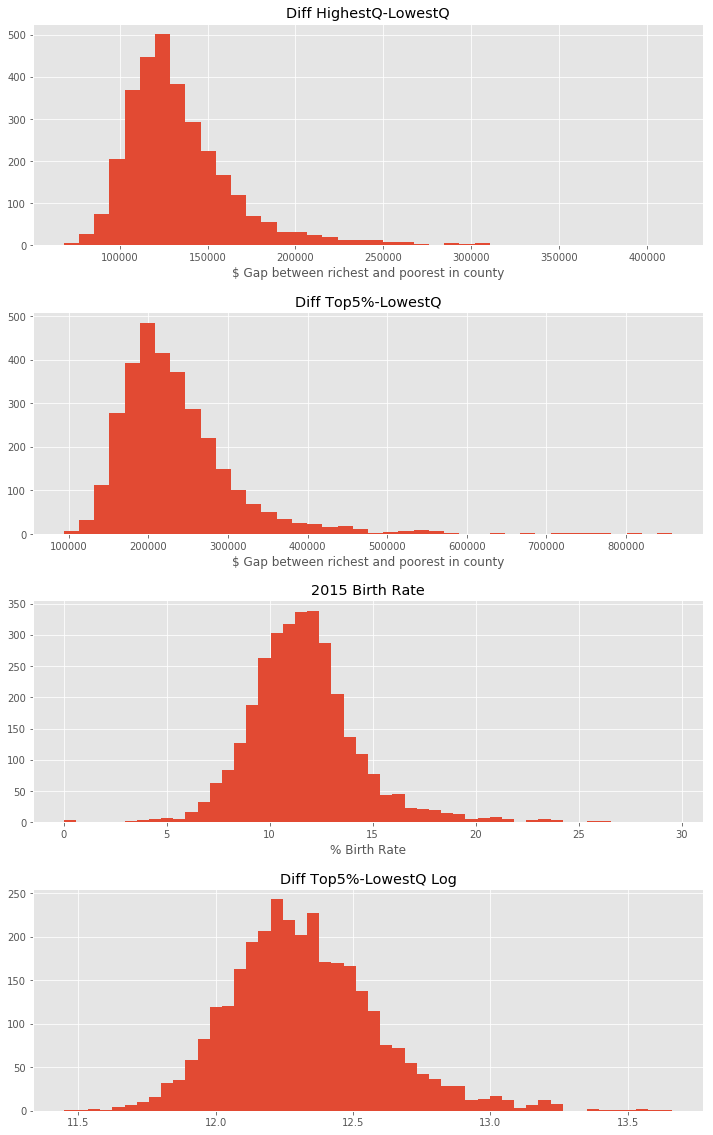

In [67]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(4,figsize=(12,20))
# visualization
quintiles.hist(column = ['Diff HighestQ-LowestQ','Diff Top5%-LowestQ'], bins= 40, sharex=True, figsize=(10,4), ax=(ax1,ax2));
birth_rate.hist(column = 'Birth_Rate_2015', bins = 50, ax=ax3)
ax1.set_xlabel('$ Gap between richest and poorest in county')
ax2.set_xlabel('$ Gap between richest and poorest in county')
ax3.set_title('2015 Birth Rate')
ax3.set_xlabel('% Birth Rate')
#log transform quintiles
quintiles['Diff Top5%-LowestQ'].apply(np.log).hist(bins=50, ax=ax4)
ax4.set_title('Diff Top5%-LowestQ Log')


### Density Histograms

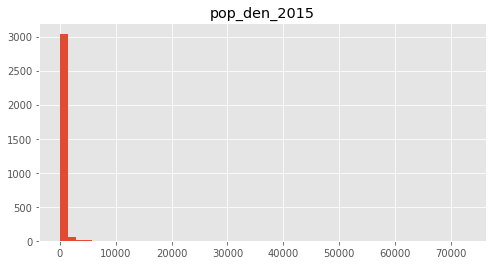

In [68]:
pop_density.hist('pop_den_2015', bins=50, figsize=(8,4));

# master[master['County_Code'] == 36081]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f164859f550>]], dtype=object)

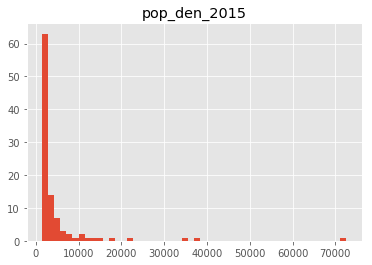

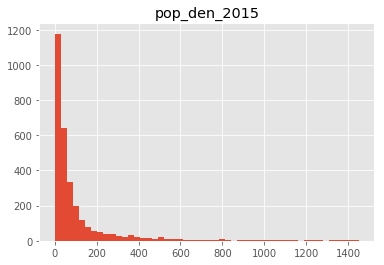

In [69]:
# split the top 100 counties by density from the rest of the counties

pop_last_100 = pop_density.sort_values('pop_den_2015')[-100:]
pop_everything_else = pop_density.sort_values('pop_den_2015')[:-100]
pop_last_100.hist('pop_den_2015', bins=50)
pop_everything_else.hist('pop_den_2015', bins=50)

This suggests that most counties are mostly white. The magnitude in the plot makes the data look imporobable, but 
the census bureau reported that as of 2016, 76.9% of the population is white. 

See https://www.census.gov/quickfacts/fact/table/US/PST045216 for further details


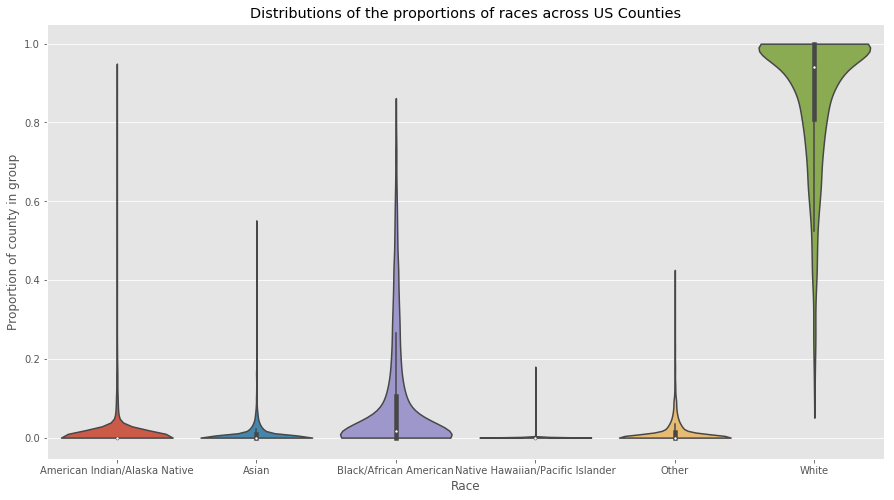

In [70]:
fig, ax = plt.subplots(1, figsize=(15,8))

sns.violinplot(data=race_pivot.loc[:,['American Indian/Alaska Native', 'Asian',
       'Black/African American', 'Native Hawaiian/Pacific Islander', 'Other',
       'White']],ax=ax, scale='count', cut=0);

ax.set_ylabel('Proportion of county in group')
ax.set_xlabel('Race')
ax.set_title('Distributions of the proportions of races across US Counties');
print('This suggests that most counties are mostly white. The magnitude in the plot makes the data look imporobable, but \n\
the census bureau reported that as of 2016, 76.9% of the population is white. \n\n\
See https://www.census.gov/quickfacts/fact/table/US/PST045216 for further details')

In [71]:
predom_white_counties = race_pivot[race_pivot['White']>=.7]
num_white_counties = len(predom_white_counties)
num_counties = len(race_pivot)
pop_US_total = race_pivot['Single_Race_Population'].sum()
pop_in_white_counties = predom_white_counties['Single_Race_Population'].sum()
percent_in_white_counties = (pop_in_white_counties/pop_US_total)*100
print('There are {} counties with at least 70% white population out of a total of {} counties in the United States'.\
      format(num_white_counties,num_counties))
print('The total population in predominantly white counties is {:.0f}, which is about {:.0f}% of the total pop'.\
     format(pop_in_white_counties,percent_in_white_counties))

There are 2662 counties with at least 70% white population out of a total of 3140 counties in the United States
The total population in predominantly white counties is 204533298, which is about 67% of the total pop


In [72]:
birth_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3142 entries, 0 to 3141
Data columns (total 7 columns):
State              3142 non-null int64
State_Name         3142 non-null object
County_Name        3142 non-null object
Pop_2015           3142 non-null int64
Births_2015        3142 non-null int64
Birth_Rate_2015    3142 non-null float64
County_Code        3142 non-null int64
dtypes: float64(1), int64(4), object(2)
memory usage: 171.9+ KB


In [73]:
'''Merge data then select for just predictors that we care about'''

merged_data = quintiles.merge(birth_rate, on='County_Code')
merged_data = merged_data.merge(race_pivot, on=['County_Code','County_State'])
merged_data = merged_data.merge(pop_density, on='County_Code')
merged_data = merged_data.merge(education_25yr, on=['County_Code','County_State'])
predictors_target = merged_data.loc[:, ['County_Code', 'County_Name','State_Name',\
                                        'Diff Top5%-LowestQ','Birth_Rate_2015', 'American Indian/Alaska Native',\
                                        'Asian','Black/African American', 'Native Hawaiian/Pacific Islander',\
                                        'Other','White', 'pop_den_2015','Less than 9th grade',\
                                        '9th to 12th grade, no diploma','High school graduate (includes equivalency)',\
                                        'Some college, no degree', "Associate's degree", "Bachelor's degree",\
                                        'Graduate or professional degree']]

In [74]:
predictors_target.head()

County_Code     County_Name State_Name  Diff Top5%-LowestQ  \
0         1001  Autauga County    Alabama              227339   
1         1003  Baldwin County    Alabama              272508   
2         1005  Barbour County    Alabama              159870   
3         1007     Bibb County    Alabama              209597   
4         1009   Blount County    Alabama              167062   

   Birth_Rate_2015  American Indian/Alaska Native     Asian  \
0        10.846281                       0.000000  0.000000   
1        11.104997                       0.006082  0.006817   
2        10.093051                       0.000000  0.000000   
3        11.211557                       0.000000  0.000000   
4        10.456859                       0.000000  0.000000   

   Black/African American  Native Hawaiian/Pacific Islander     Other  \
0                0.194417                               0.0  0.000000   
1                0.097719                               0.0  0.009754   
2                0.479280                               0.0  0.035313   
3                0.218554                               0.0  0.000000   
4                0.015852                               0.0  0.000000   

      White  pop_den_2015  Less than 9th grade  9th to 12th grade, no diploma  \
0  0.805583     93.107956             0.038382                       0.089815   
1  0.879629    128.134341             0.032007                       0.072810   
2  0.485407     29.935234             0.092088                       0.174872   
3  0.781446     36.273075             0.069486                       0.124000   
4  0.984148     89.442267             0.069656                       0.145326   

   High school graduate (includes equivalency)  Some college, no degree  \
0                                     0.335417                 0.225860   
1                                     0.287815                 0.226860   
2                                     0.345066                 0.191036   
3                                     0.420628                 0.218376   
4                                     0.334424                 0.223990   

   Associate's degree  Bachelor's degree  Graduate or professional degree  
0            0.078224           0.134833                         0.097470  
1            0.090656           0.192612                         0.097240  
2            0.071778           0.075074                         0.050085  
3            0.061040           0.060529                         0.045940  
4            0.097696           0.086175                         0.042732

In [75]:
def corr_heat(df):
    corr = df.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=(12, 12))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5},xticklabels=corr.index, yticklabels=corr.columns)
    plt.xticks(rotation=60, ha="right")
    plt.yticks(rotation=0)
    ax.set_title("Correlation Heat Map")
    plt.show()

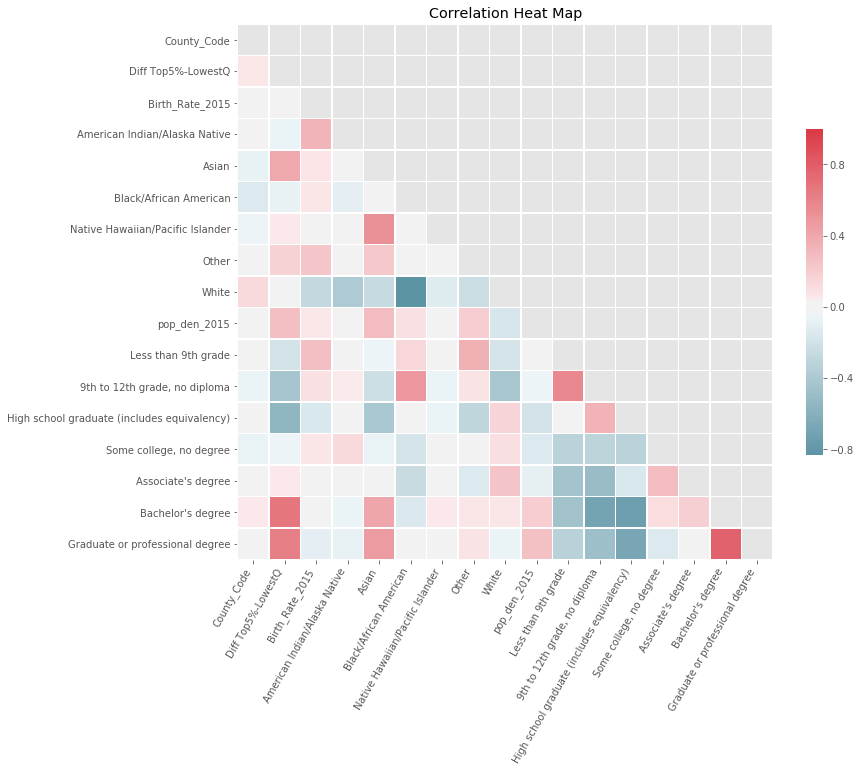

In [76]:
corr_heat(pd.DataFrame(predictors_target))

Covariance Notes:
- Covariance between proportion of pop with a Bachelor's degree and proportion of pop with a graduate degree. **How deal with this? Chose one? Can somehow parse out into parts that don't covary?**
- High covariance between proportion of Bachelor's/Grad degrees and income inequality. This is the opposite of what I expected given that higher education is said to facilitate socioeconomic mobility while income inequality hinders it.
- Higher proportion of population with High School as highest level of educational attainment strongly *inversely* covaries with income inequality. Is this because in those towns, everybody is poor?

/home/alex/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  """Entry point for launching an IPython kernel.


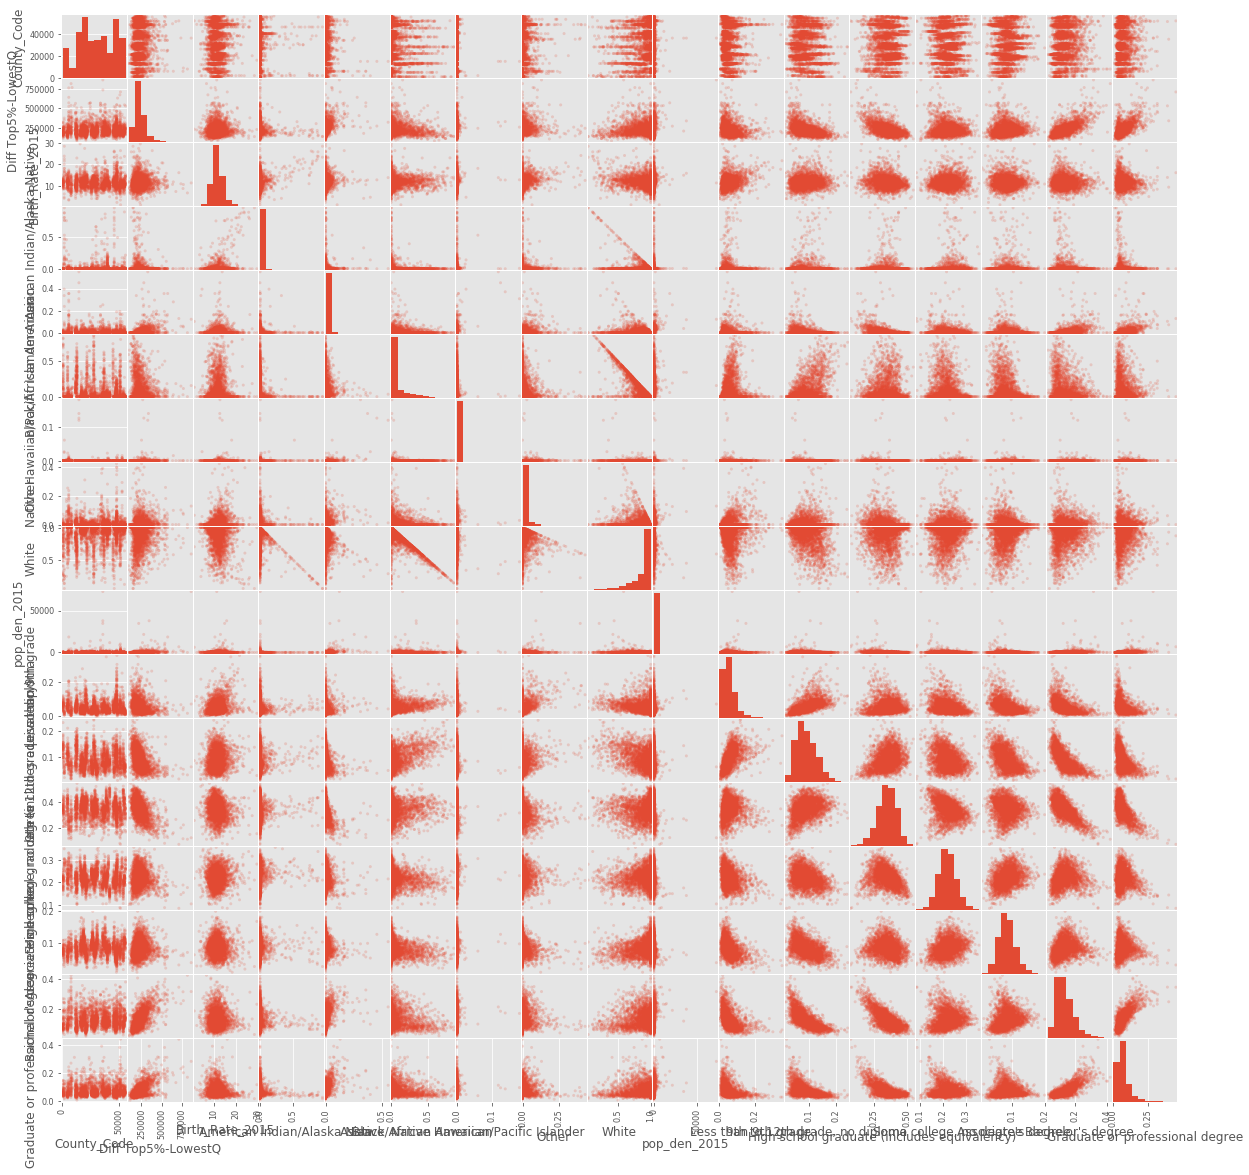

In [77]:
scattermatrix = scatter_matrix(predictors_target, alpha=0.2,figsize=(20,20), diagonal="hist")

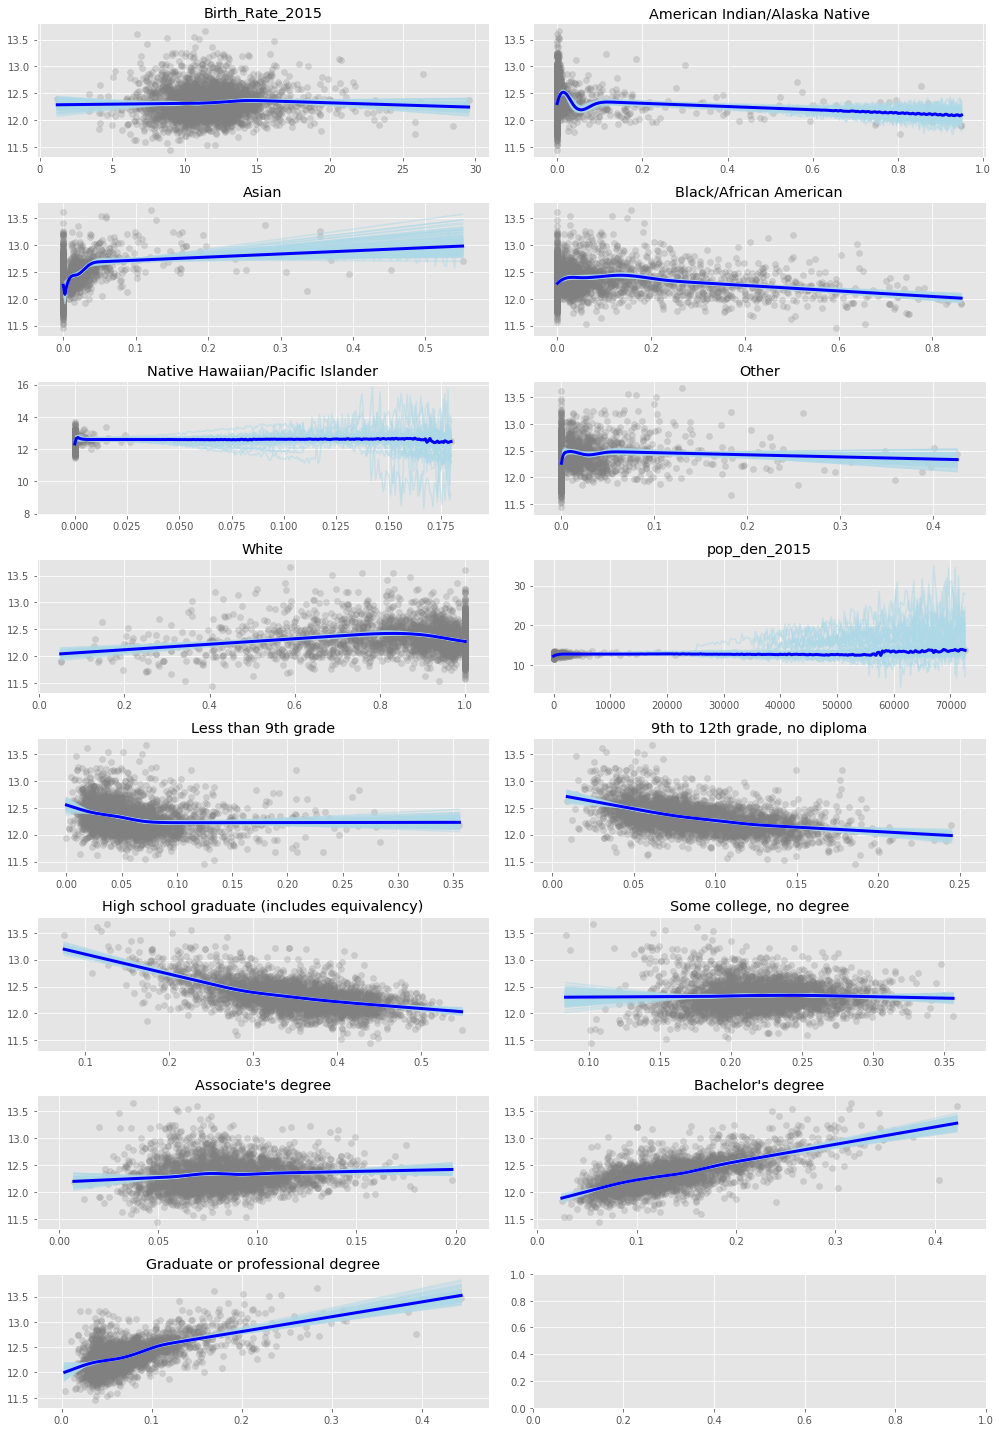

In [78]:
#Plot univariate plots against log of income inequality
fig, axs = plt.subplots(8, 2, figsize=(14, 20))
l1=['Birth_Rate_2015', 'American Indian/Alaska Native',\
    'Asian','Black/African American', 'Native Hawaiian/Pacific Islander',\
    'Other','White', 'pop_den_2015','Less than 9th grade',\
    '9th to 12th grade, no diploma','High school graduate (includes equivalency)',\
    'Some college, no degree', "Associate's degree", "Bachelor's degree",\
    'Graduate or professional degree']

univariate_plot_names = predictors_target[l1]

for name, ax in zip(univariate_plot_names, axs.flatten()):
    plot_univariate_smooth(ax,
                           predictors_target[name].values.reshape(-1, 1),
                           np.log(predictors_target['Diff Top5%-LowestQ']),
                           bootstrap=100)
    ax.set_title(name)
fig.tight_layout()

## Summary of EDA

### Source data considerations
- Race data only described people who identify as a single race, so it does not include everyone in the population.
- Education data only includes people 25 or older as that seems to be the standard way the census measures a population's educational attainment. 

### Impressions from data visualization
- Target variable, income inequality, not normally distributed because:
            + Extreme values
            + Zero bound
    - To deal with this, took the log of the target in the target variable, which resulted in a more normal distribution
- American counties are heavily weighted toward white populations

### Variable treatment to-do:
- Need to deal with high covariance and inverse covariance in predictors
- variables are mostly linearly related with the log of income inequality. Exceptions are:
    - Asian - weighted by zeros but in a way that looks like it might be significant
    - White - right around 90% it looks like an increase in proportion of whites results in a decrease in income inequality
    - Less than 9th grade, apparent inflection point at 7.5%
- Add in states dummies

In [79]:
# Pipeline
# get rid of outliers
# spline the variables that aren't linearly related with target
# standardize to mean 0 and stdev = 1


- ANOVA for states - does log(income_inequality) vary significantly by state - *not gonna do for mvp, instead will focus on linear regression*
- lasso linear regression for interpretability of coefficients
    - Lasso vs ridge does not actually impact interpretability of coefficients
    - Lasso will randomly drop one of two correlated variables. We don't want that because undergrad and grad are meaningflly different.
    - Will instead be using ridge to keep in variables but minimize impact.
- k fold to determine alpha for ridge
- train_test_split
    - stratify sample by state if including state as explanatory variable
    - potential supplement state samples with techniques from Monday
- bootstrap

# Define y and X and train/test/split

In [80]:
# Define y and X
y = np.log(predictors_target['Diff Top5%-LowestQ'])
X = predictors_target.loc[:, ['Birth_Rate_2015','pop_den_2015','American Indian/Alaska Native','Asian'\
                              ,'Black/African American','Native Hawaiian/Pacific Islander','Other','White', \
                              'Less than 9th grade','9th to 12th grade, no diploma',\
                              'High school graduate (includes equivalency)','Some college, no degree', \
                              "Associate's degree", "Bachelor's degree",'Graduate or professional degree']]


# Test_train_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Basic Linear Regression
- Train/test split then pipeline
- Pipeline will only normalize variables
    - no spline on variables
    - will not get rid of outliers
- Linear regression

#### Plan
    - show coefficients
    - bootstap coefficients and show the distributions
    - measure how well the model is doing
    - show predictions vs actuals

## Pipeline

In [81]:
# Pipeline is just standardize predictors and then feed them into a linear model. 
simple_linear_model_pipeline = Pipeline([
    ('Standardizer', StandardScaler()),
    ('Linear Regression', LinearRegression())
])

# Fit on X_train, standardize/predict on X_test

simple_linear_model = simple_linear_model_pipeline
simple_linear_model.fit(X_train, y_train)
y_predict_linear = simple_linear_model.predict(X_test)

In [82]:
display_coef(simple_linear_model.named_steps['Linear Regression'], X.columns)
                                  

Name                               Parameter Estimate  
-------------------------------------------------------
Birth_Rate_2015                    0.01806817990975067 
pop_den_2015                       0.0017568031629703693
American Indian/Alaska Native      -1024513509225.937  
Asian                              -396747796183.9345  
Black/African American             -1839395130505.9443 
Native Hawaiian/Pacific Islander   -67387007534.84388  
Other                              -447795610890.97015 
White                              -2136556949581.721  
Less than 9th grade                -5559243485167.923  
9th to 12th grade, no diploma      -5516512542767.207  
High school graduate (includes equivalency)-10646281040539.324 
Some college, no degree            -5762983701761.941  
Associate's degree                 -3806055768633.7607 
Bachelor's degree                  -8181307568495.037  
Graduate or professional degree    -6262869097402.356  


## Bootstrap Coefficients

In [83]:
# This creates a list of models, one for each bootstrap sample.
standardizer = StandardScaler()
standardizer.fit(X_train)
X_train_standard = standardizer.transform(X_train)

models = bootstrap_train(
    LinearRegression, 
    X_train_standard, 
    y_train.values
)

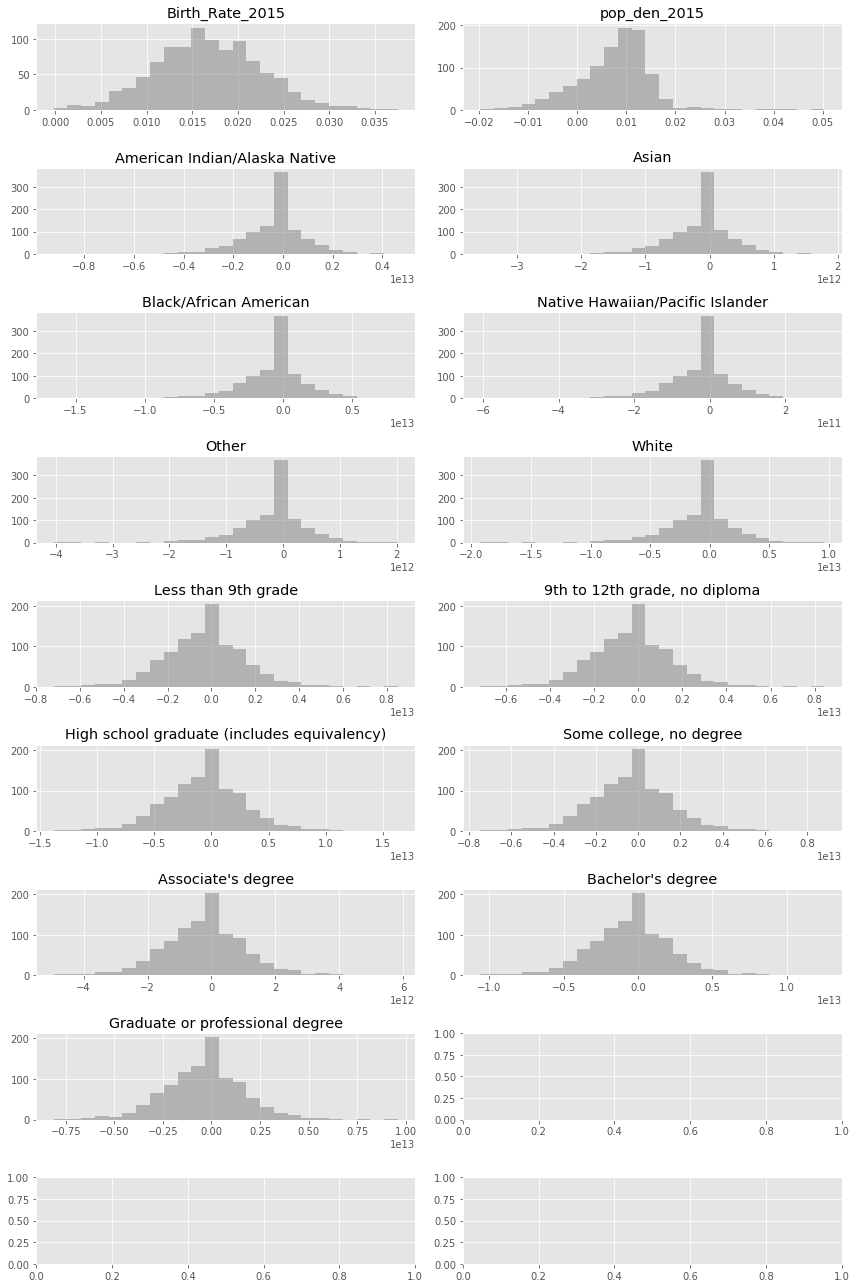

In [85]:
fig, axs = plot_bootstrap_coefs(models, X_train.columns, n_col=2)
fig.tight_layout()

# How well is the Linear model doing?
    - Standard measurement - root mean squared error
    - Predictions vs actuals
    - Plot residuals

In [87]:
def plot_many_predicteds_vs_actuals(var_names, X_test, y_test, y_predict, n_bins=50):
    fig, axs = plt.subplots(len(var_names), figsize=(12, 4.5*len(var_names)))
    for ax, name in zip(axs, var_names):
        x = X_test[name]
        predicteds_vs_actuals(ax, x, y_test, y_predict)
        ax.set_title("{} Predicteds vs. Actuals".format(name))
    return fig, axs

In [88]:
def residual_plot(ax, x, y, y_hat, n_bins=50):
    fig.tight_layout()
    residuals = y - y_hat
    ax.axhline(0, color="black", linestyle="--")
    ax.scatter(x, residuals, color="grey", alpha=0.5)
    ax.set_ylabel("Residuals ($y - \hat y$)")

In [89]:
def plot_many_residuals(var_names, X_test, y_test, y_predict, n_bins=50):
    fig, axs = plt.subplots(len(var_names), figsize=(12, 3*len(var_names)))
    for ax, name in zip(axs, var_names):
        x = X_test[name]
        residual_plot(ax, x, y_test, y_predict)
        ax.set_xlabel(name)
        ax.set_title("Model Residuals by {}".format(name))
    return fig, axs

In [102]:
rmse_linear = mean_squared_error(y_test, y_predict_linear)**0.5
print('The root mean squared error for this model is {:.4f}'.format(rmse_linear))
mse_linear =  mean_squared_error(y_test, y_predict_linear)
print(mse_linear)

The root mean squared error for this model is 0.2022
0.0408752624132


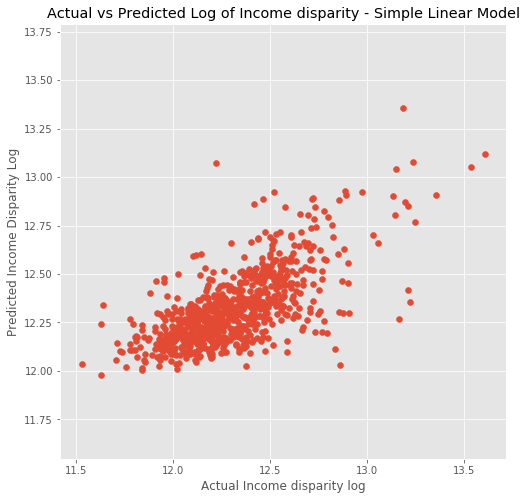

In [103]:
# scatter of actuals vs predicted overall
fig = plt.figure(figsize=(8,8))
plt.scatter(y_test, y_predict_linear)
plt.ylabel("Predicted Income Disparity Log")
plt.xlabel("Actual Income disparity log")
plt.title('Actual vs Predicted Log of Income disparity - Simple Linear Model')
plt.axis('equal');

In [104]:
# def residual_plot(ax, x, y, y_hat, n_bins=50):

Text(0.5,6,'$\\hat y$')

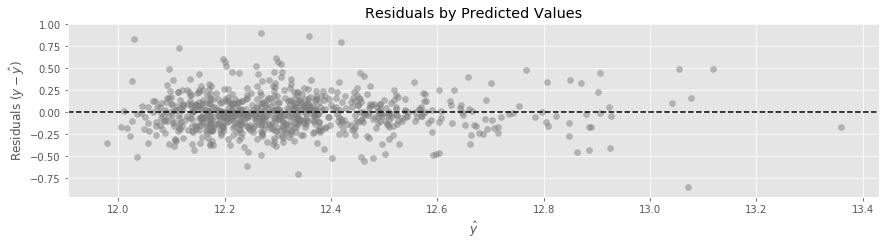

In [105]:
#Scatter of 
fig, ax = plt.subplots(figsize=(12, 3))
fig.tight_layout()
residuals = y_test - y_predict_linear
ax.axhline(0, color="black", linestyle="--")
ax.scatter(y_predict_linear, residuals, color="grey", alpha=0.5)
ax.set_ylabel("Residuals ($y - \hat y$)")
ax.set_title("Residuals by Predicted Values")
ax.set_xlabel("$\hat y$")

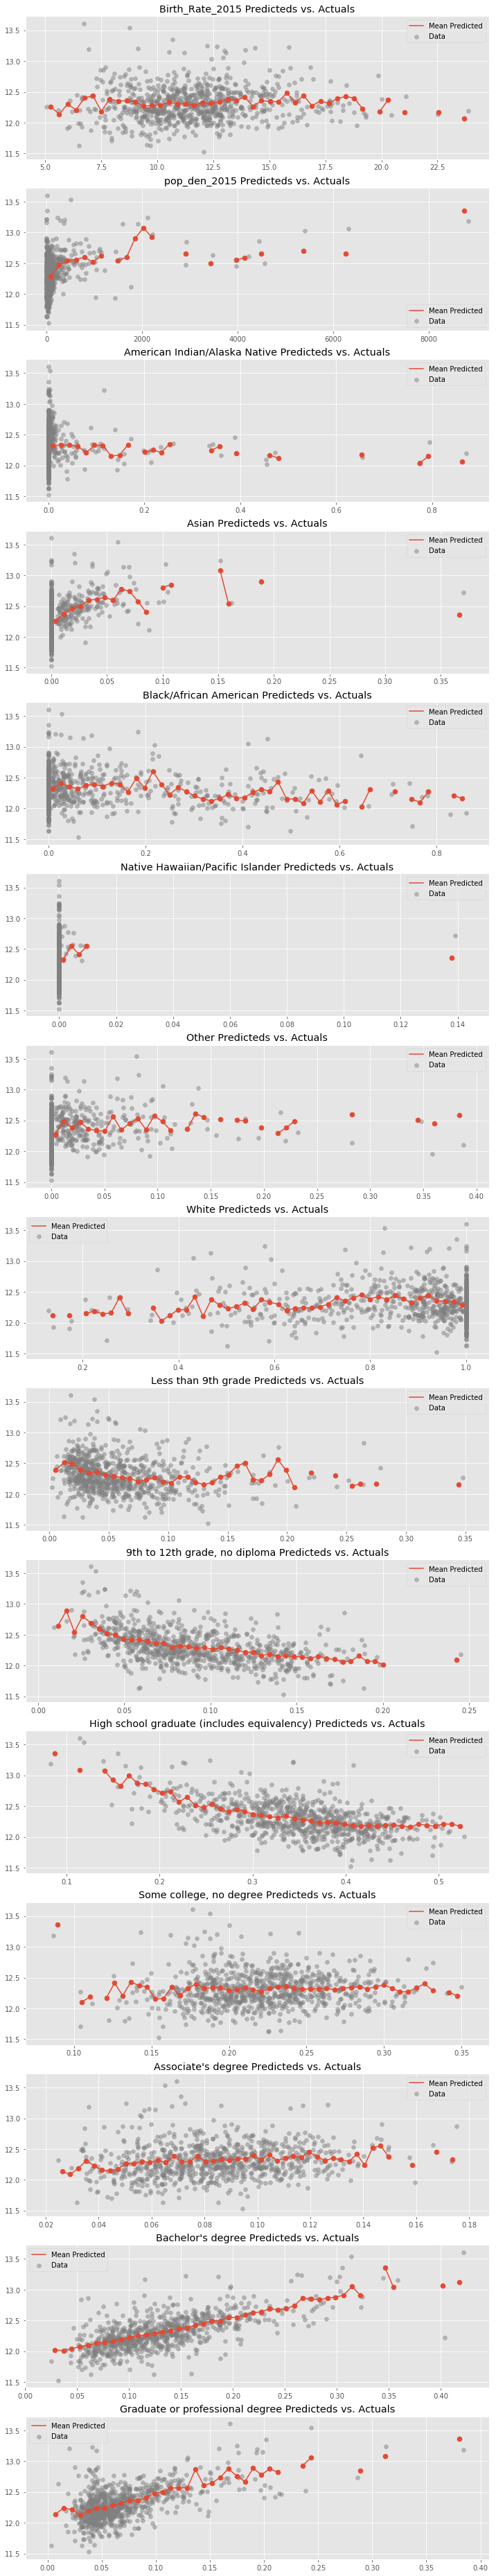

In [106]:
plot_many_predicteds_vs_actuals(X.columns, X_test, y_test, y_predict_linear);

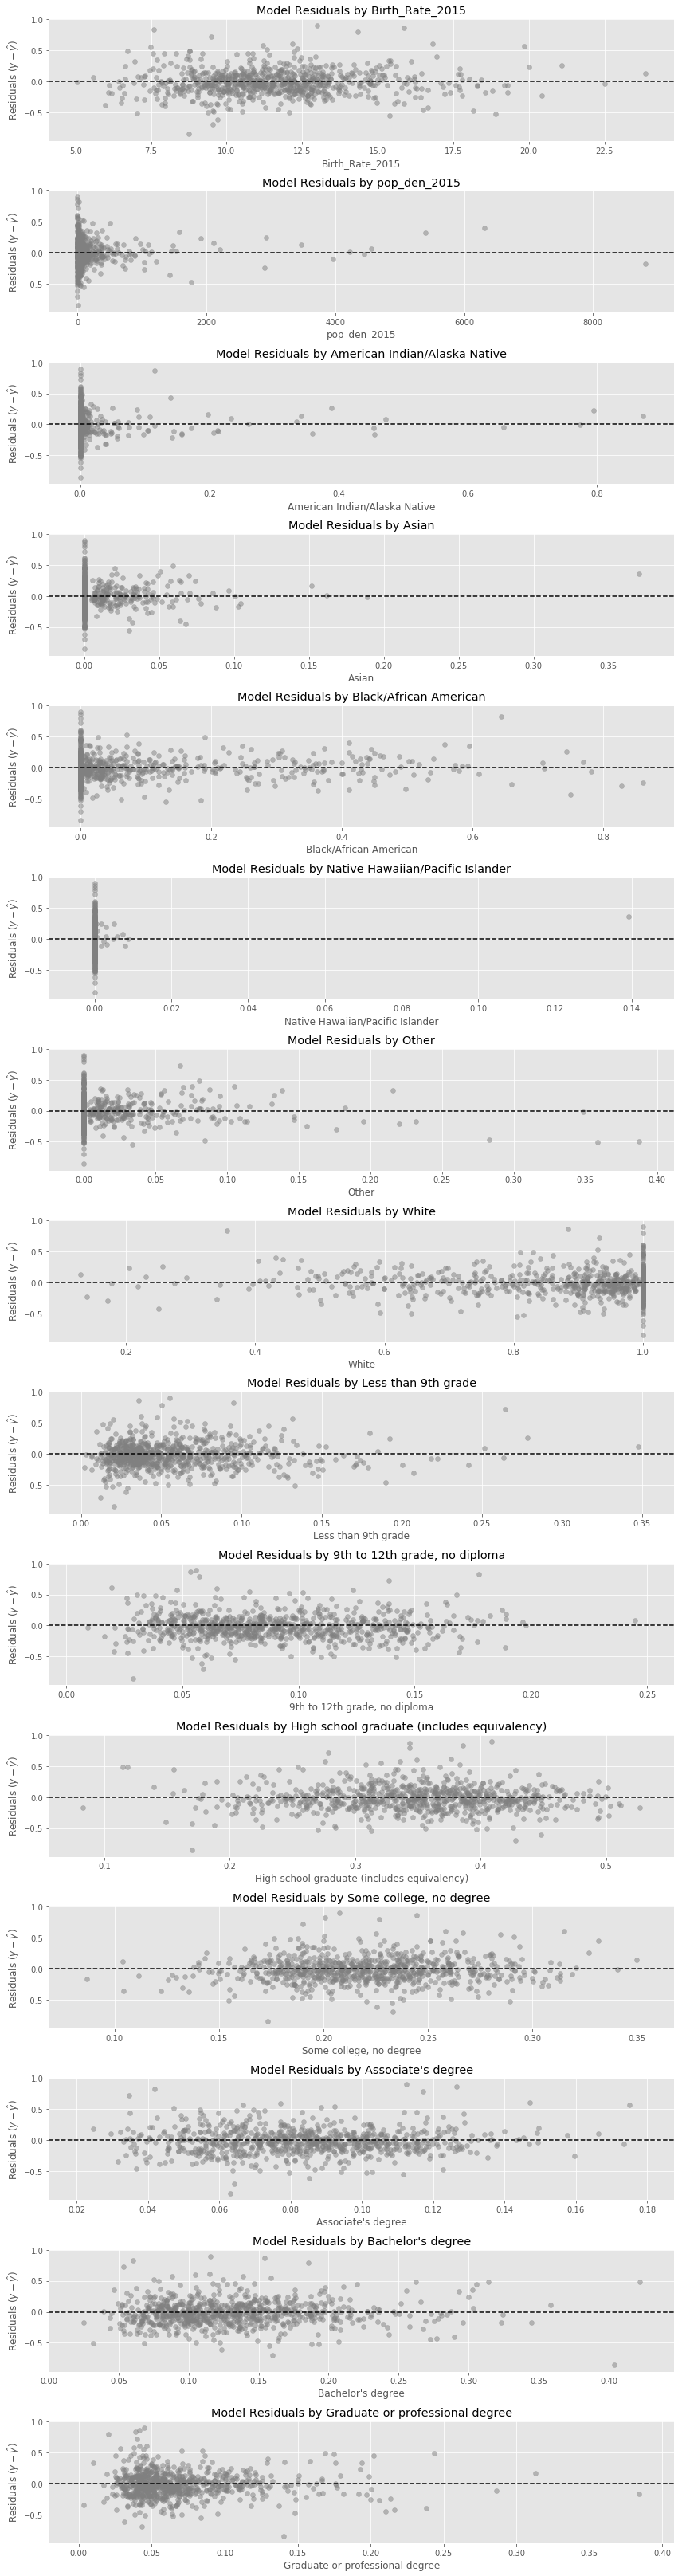

In [107]:
fig, axs = plot_many_residuals(X.columns, X_test, y_test, y_predict_linear)
fig.tight_layout()

# Ridge Regression
- Train/test split then pipeline
- Pipeline will
    - not gonna spline any variables to keep interpretibility
    - normalize all predictors
    - **not**  get rid of outliers because I think outliers are important to predict
- Ridge regression
    - use k folds to figure out 

#### Plan
    - show coefficients
    - bootstap coefficients and show the distributions
    - measure how well the model is doing
    - show predictions vs actuals

## Pipeline

In [108]:
# Define y and X - the same as above for the linear model
# y = np.log(predictors_target['Diff Top5%-LowestQ'])
# X = predictors_target.loc[:, ['Birth_Rate_2015','pop_den_2015','American Indian/Alaska Native','Asian'\
#                               ,'Black/African American','Native Hawaiian/Pacific Islander','Other','White', \
#                               'Less than 9th grade','9th to 12th grade, no diploma',\
#                               'High school graduate (includes equivalency)','Some college, no degree', \
#                               "Associate's degree", "Bachelor's degree",'Graduate or professional degree']]


# Test_train_split
# X_train, X_test, y_train, y_test = train_test_split(X, y)

# Fit on X_train, standardize/predict on X_test

standardizer = StandardScaler()
standardizer.fit(X_train)
X_train_standardized = standardizer.transform(X_train)
X_test_standardized = standardizer.transform(X_test)


## Use k-fold cross-validation to pick an alpha for the Ridge Regression

In [110]:
def cv(X, y, model, param_dict, n_folds=10):
    """Estimate the in- and out-of-sample error of a model using cross
    validation.
 
    Parameters
    ----------
 
    X: np.array
      Matrix of predictors.
 
    y: np.array
      Target array.
 
    model: sklearn model object.
      The estimator to fit.  Must have fit and predict methods.
 
    param_dict: dictionary of paramters to use in sklearn model
    
    n_folds: int
      The number of folds in the cross validation.
 
    random_seed: int
      A seed for the random number generator, for repeatability.
 
    Returns
    -------
 
    results_train, results_test: tuple of arrays
      The training and testing errors for each fold of cross validation.
    """
    kf = KFold(n_splits=n_folds)
    results_train = np.array([])  
    results_test = np.array([])    #np.array([])
    for train_index, test_index in kf.split(X):
        # Split into train and test
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        # Standardize data, fit on training set, transform training and test.
        scaler = StandardScaler()
        scaler.fit(X_train)
        scaled_X_train = scaler.transform(X_train)
        scaled_X_test = scaler.transform(X_test)
        # Fit ridge regression to training data.
        regularized = model(**param_dict)
        regularized.fit(scaled_X_train, y_train)
        # Make predictions.
        reg_predict_train = regularized.predict(X_train)
        reg_predict_test = regularized.predict(X_test)
        # Calclate MSE.
        mse_train = mean_squared_error(reg_predict_train, y_train)
        mse_test = mean_squared_error(reg_predict_test, y_test)
        # Record the MSE in a numpy array.
        results_train = np.append(results_train, mse_train)
        results_test = np.append(results_test, mse_test)
    return results_train, results_test

In [111]:
def k_fold_to_pick_alpha(X, y, model, alphas, n_folds=10, **kwargs):
    """Train a regularized regression model using cross validation at various
    values of alpha.
 
    Parameters
    ----------
 
    X: np.array
      Matrix of predictors.
 
    y: np.array
      Target array.
 
    model: sklearn model class
      A class in sklearn that can be used to create a regularized regression
      object.  Options are `Ridge` and `Lasso`.
 
    alphas: numpy array
      An array of regularization parameters.
 
    n_folds: int
      Number of cross validation folds.
 
    Returns
    -------
 
    
    """
    cv_errors_train = pd.DataFrame(np.empty(shape=(n_folds, len(alphas))),
                                     columns=alphas)
    cv_errors_test = pd.DataFrame(np.empty(shape=(n_folds, len(alphas))),
                                        columns=alphas)
    for alpha in alphas:
        param_dict = {'alpha': alpha}
        mses = cv(X, y, model, param_dict, n_folds)
        cv_errors_train[alpha] = mses[0]
        cv_errors_test[alpha] = mses[1]
    
    # Average error RMSEs for each alpha to determine which alpha creates a model that generalizes best.
    alpha_error_means = cv_errors_test.mean()
    min_mse = alpha_error_means.min()
    best_alpha = np.argmin(alpha_error_means)
    return cv_errors_test, alpha_error_means, best_alpha, min_mse

In [137]:
orders_of_magnitude = np.arange(-2,15)
alphas = (np.ones(len(orders_of_magnitude))*10)**orders_of_magnitude
cv_errors_test_o, alpha_error_means_o, best_alpha_o, min_rmse_o = k_fold_to_pick_alpha(X_train_standardized, y_train.values, Ridge, alphas, n_folds=10)

print('The best order of magnitude for alpha is around {:.0g}, which results in an average \
mean \nsquared error of {:.7f}.'.format(best_alpha_o, min_rmse_o))

print('I will now test alphas around that order of magnitude to attempt to narrow the value of min_mse \
down \nfurther')

The best order of magnitude for alpha is around 1e+02, which results in an average mean 
squared error of 0.0371022.
I will now test alphas around that order of magnitude to attempt to narrow the value of min_mse down 
further


In [138]:
# alphas = np.linspace(68,72,20)
# cv_errors_test, alpha_error_means, best_alpha, min_mse = k_fold_to_pick_alpha\
# (X_train_standardized, y_train.values, Ridge, alphas, n_folds=10)


# print(alpha_error_means, best_alpha)

In [139]:
alphas = np.linspace(68,72,20)
cv_errors_test, alpha_error_means, best_alpha, min_mse = k_fold_to_pick_alpha(X_train_standardized, y_train.values, Ridge, alphas, n_folds=10)
print('Narrowing the range to zero in on the best alpha resulted in an alpha of {:.2g},\
which \nminimized the average root mean squared error at {:.7f}.\n\nThis is the same as the \
error we got with alpha=100 and is a bit better than the the simple linear regression mse'.format(best_alpha, min_rmse))

Narrowing the range to zero in on the best alpha resulted in an alpha of 70,which 
minimized the average root mean squared error at 0.0371022.

This is the same as the error we got with alpha=100 and is a bit better than the the simple linear regression mse


In [143]:
# check my work with sklearn cross_val
ridge = Ridge(alpha=100)
cvs = cross_val_score(ridge, X_train_standard, y_train, cv=10, scoring = make_scorer(mean_squared_error))
print(cvs)
print(cvs.mean())

[ 0.04082004  0.04785506  0.04134709  0.03179427  0.03390168  0.03624735
  0.03504596  0.03888647  0.03536017  0.02978742]
0.037104551758


In [43]:
'''sklearn.model_selection.cross_val_score(estimator, X, y=None, groups=None, scoring=None, cv=None, 
n_jobs=1, verbose=0, fit_params=None, pre_dispatch=‘2*n_jobs’)'''

# Check my work with sklearn gridsearch


<function sklearn.model_selection._validation.cross_val_score>

## With alpha chosen, fit Ridge Regression on X_train and predict on X_test

In [44]:
def display_coef(model, coef_names):
    """Pretty print a table of the parameter estimates in a linear model.

    Parameters
    ----------
    model: A fit sklean object with a `coef_` attribute.

    coef_names: A list of names associated with the coefficients.
    """
    print("{:<35}{:<20}".format("Name", "Parameter Estimate"))
    print("-"*(35 + 20))
    for coef, name in zip(model.coef_, coef_names):
        row = "{:<35}{:<20f}".format(name, coef)
        print(row)

In [45]:
ridge_regression = Ridge(alpha = 39)
ridge_regression.fit(X_train_standardized, y_train)
y_predict = ridge_regression.predict(X_test_standardized)
mse = mean_squared_error(y_predict, y_test)

display_coef(ridge_regression, X_test.columns)

Name                               Parameter Estimate  
-------------------------------------------------------
Birth_Rate_2015                    0.016870            
pop_den_2015                       0.011053            
American Indian/Alaska Native      -0.009374           
Asian                              0.019243            
Black/African American             -0.002543           
Native Hawaiian/Pacific Islander   -0.003374           
Other                              0.026530            
White                              -0.001991           
Less than 9th grade                -0.015266           
9th to 12th grade, no diploma      -0.038606           
High school graduate (includes equivalency)-0.037574           
Some college, no degree            -0.028966           
Associate's degree                 -0.006477           
Bachelor's degree                  0.091354            
Graduate or professional degree    0.024262            


# How well is the Ridge model doing?
    - Standard measurement - root mean squared error
    - Predictions vs actuals
    - Plot residuals

In [46]:
rmse = mean_squared_error(y_test, y_predict)**0.5
print('The root mean squared error for this model is {:.4f}'.format(rmse))

The root mean squared error for this model is 0.1882


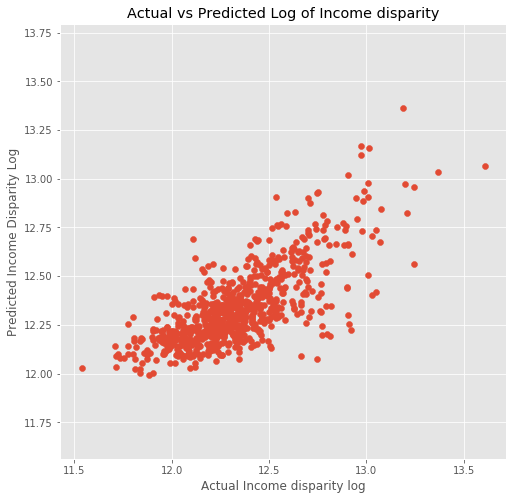

In [47]:
# scatter of actuals vs predicted overall
fig = plt.figure(figsize=(8,8))
plt.scatter(y_test, y_predict)
plt.ylabel("Predicted Income Disparity Log")
plt.xlabel("Actual Income disparity log")
plt.title('Actual vs Predicted Log of Income disparity')
plt.axis('equal');

In [48]:
# def residual_plot(ax, x, y, y_hat, n_bins=50):

Text(0.5,6,'$\\hat y$')

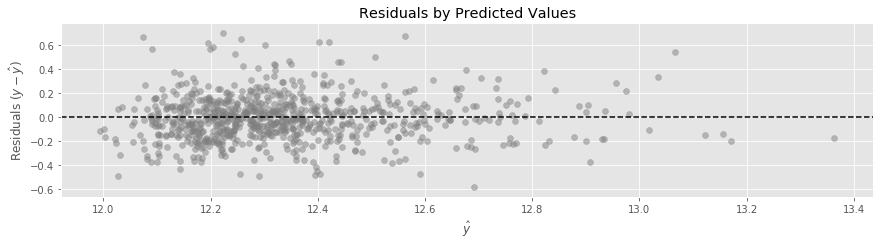

In [49]:
#Scatter of 
fig, ax = plt.subplots(figsize=(12, 3))
fig.tight_layout()
residuals = y_test - y_predict
ax.axhline(0, color="black", linestyle="--")
ax.scatter(y_predict, residuals, color="grey", alpha=0.5)
ax.set_ylabel("Residuals ($y - \hat y$)")
ax.set_title("Residuals by Predicted Values")
ax.set_xlabel("$\hat y$")

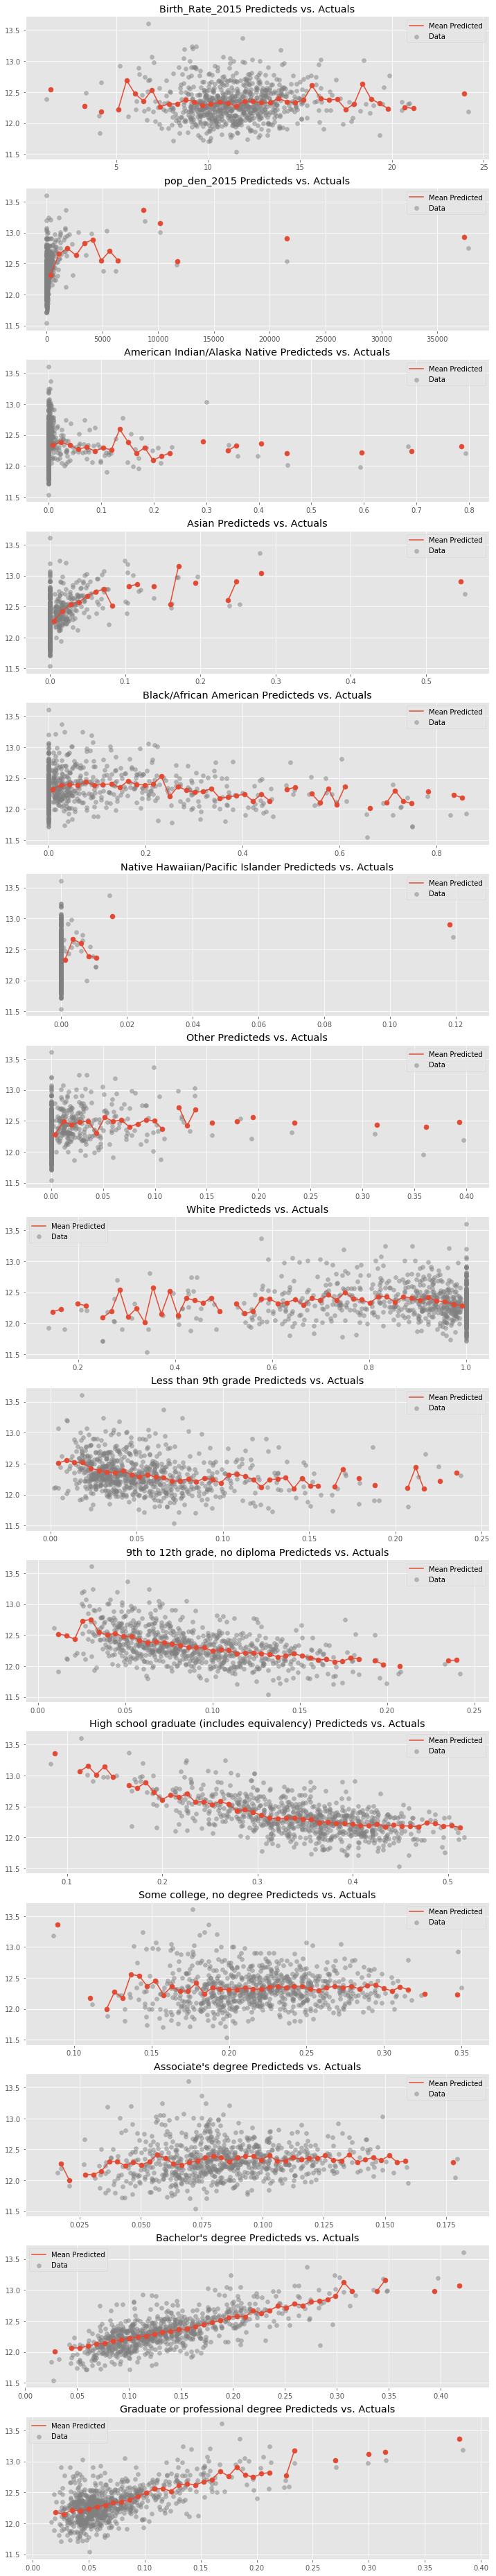

In [50]:
plot_many_predicteds_vs_actuals(X.columns, X_test, y_test, y_predict);

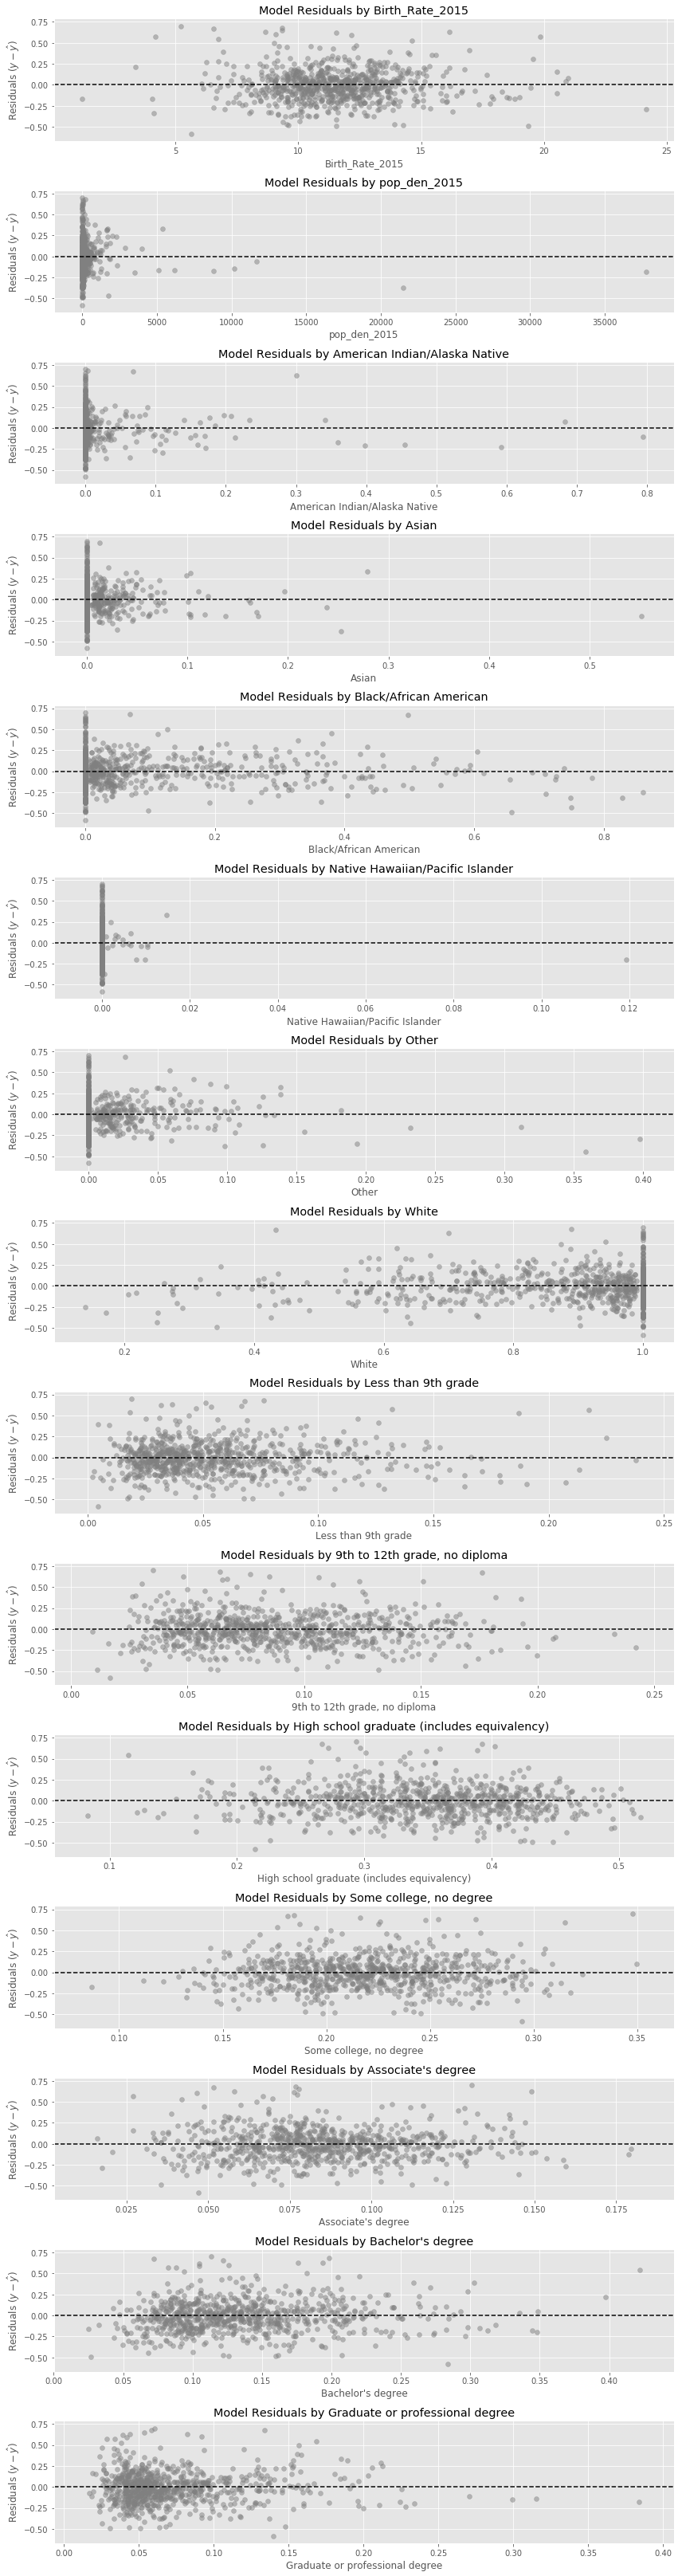

In [51]:
fig, axs = plot_many_residuals(X.columns, X_test, y_test, y_predict)
fig.tight_layout()